# **Revenue Reconciliation and Data Quality Analysis**
## **Order-Level Revenue Definitions, Coverage, and Validation**

## **Purpose**

This analysis was conducted to understand why revenue figures differed across operational and financial reports and to identify whether discrepancies were caused by data quality issues or metric definition differences.

The goal is not to maximize revenue, but to restore confidence in reported metrics by reconciling transaction-level data at the correct grain.

## **Creating environment and paths**

In [ ]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
import os
import pandas as pd

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 140)
pd.options.mode.copy_on_write = True

## **1. Data Scope and Assumptions**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

PROJECT_ROOT = Path("/content/drive/MyDrive/revenue-kpi-reconciliation")
RAW_DIR = PROJECT_ROOT / "data" / "raw"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
OUTPUTS_DIR = PROJECT_ROOT / "outputs"
SQL_DIR = PROJECT_ROOT / "sql"
DOCS_DIR = PROJECT_ROOT / "docs"

for p in [RAW_DIR, PROCESSED_DIR, OUTPUTS_DIR, SQL_DIR, DOCS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

PROJECT_ROOT.as_posix()

Mounted at /content/drive


'/content/drive/MyDrive/revenue-kpi-reconciliation'

## **2. Data Ingestion and Verification**

Here, I am verifying the raw inputs only. No transformations here.
Raw data is treated as immutable.

Core tables for reconciliation:

*   orders
*   order_items
*   order_payments
*   customers

In [ ]:
# Let's verify that the dataset files exist
DATASET_DIR = RAW_DIR / "olist_dataset" / "olist"

required_files = {
    "orders": DATASET_DIR / "olist_orders_dataset.csv",
    "items": DATASET_DIR / "olist_order_items_dataset.csv",
    "payments": DATASET_DIR / "olist_order_payments_dataset.csv",
    "customers": DATASET_DIR / "olist_customers_dataset.csv",
}

missing = [name for name, path in required_files.items() if not path.exists()]
if missing:
    raise FileNotFoundError(f"Missing required files: {missing}. Check DATASET_DIR={DATASET_DIR}")

sorted([p.name for p in DATASET_DIR.glob("*.csv")])

['olist_customers_dataset.csv',
 'olist_geolocation_dataset.csv',
 'olist_order_items_dataset.csv',
 'olist_order_payments_dataset.csv',
 'olist_order_reviews_dataset.csv',
 'olist_orders_dataset.csv',
 'olist_products_dataset.csv',
 'olist_sellers_dataset.csv',
 'product_category_name_translation.csv']

In [ ]:
# Load core tables needed for the analysis
def read_csv(path: Path) -> pd.DataFrame:
    return pd.read_csv(path, low_memory=False)

orders = read_csv(required_files["orders"])
items = read_csv(required_files["items"])
payments = read_csv(required_files["payments"])
customers = read_csv(required_files["customers"])

# Basic schema sanity checks
required_cols = {
    "orders": {"order_id", "customer_id"},
    "items": {"order_id", "order_item_id", "price", "freight_value"},
    "payments": {"order_id", "payment_value"},
    "customers": {"customer_id", "customer_unique_id"},
}

tables = {"orders": orders, "items": items, "payments": payments, "customers": customers}
missing_cols = {
    name: sorted(list(cols - set(df.columns)))
    for name, (df, cols) in zip(tables.keys(), [(tables[k], required_cols[k]) for k in tables])
    if (required_cols[name] - set(df.columns))
}
if missing_cols:
    raise ValueError(f"Missing expected columns: {missing_cols}")

summary = pd.DataFrame(
    {
        "table": list(tables.keys()),
        "rows": [df.shape[0] for df in tables.values()],
        "cols": [df.shape[1] for df in tables.values()],
        "order_id_nunique": [
            tables["orders"]["order_id"].nunique(),
            tables["items"]["order_id"].nunique(),
            tables["payments"]["order_id"].nunique(),
            None,
        ],
        "order_id_dup_rows": [
            tables["orders"].shape[0] - tables["orders"]["order_id"].nunique(),
            tables["items"].shape[0] - tables["items"]["order_id"].nunique(),
            tables["payments"].shape[0] - tables["payments"]["order_id"].nunique(),
            None,
        ],
    }
)

summary

,table,rows,cols,order_id_nunique,order_id_dup_rows
0,orders,99441,8,99441.0,0.0
1,items,112650,7,98666.0,13984.0
2,payments,103886,5,99440.0,4446.0
3,customers,99441,5,NaN,NaN


## **3. Grain and Duplication Risk**

Before calculating revenue, we confirm the “grain”:

*   orders: one row per order_id
*   items: multiple rows per order_id (multi-item orders)
*   payments: multiple rows per order_id (installments, split payments)

This is the primary risk for inflated metrics when joining tables.

In [ ]:
# Grain check: how many rows exist per order_id in each table?
orders_per_order = orders.groupby("order_id", sort=False).size()
items_per_order = items.groupby("order_id", sort=False).size()
payments_per_order = payments.groupby("order_id", sort=False).size()

def grain_stats(s: pd.Series) -> dict:
    return {
        "mean_rows_per_order": float(s.mean()),
        "p95_rows_per_order": float(s.quantile(0.95)),
        "max_rows_per_order": int(s.max()),
        "pct_orders_with_multiple_rows": float(s.gt(1).mean() * 100),
    }

grain = pd.DataFrame(
    [
        {"table": "orders", "order_id_nunique": orders["order_id"].nunique(), "rows": len(orders), **grain_stats(orders_per_order)},
        {"table": "items", "order_id_nunique": items["order_id"].nunique(), "rows": len(items), **grain_stats(items_per_order)},
        {"table": "payments", "order_id_nunique": payments["order_id"].nunique(), "rows": len(payments), **grain_stats(payments_per_order)},
    ]
)

grain

,table,order_id_nunique,rows,mean_rows_per_order,p95_rows_per_order,max_rows_per_order,pct_orders_with_multiple_rows
0,orders,99441,99441,1.000000,1.0,1,0.000000
1,items,98666,112650,1.141731,2.0,21,9.935540
2,payments,99440,103886,1.044710,1.0,29,2.977675


In [ ]:
# Monetary sanity checks: expect non-negative values across all transaction tables
money_checks = {
    "items.price_min": float(items["price"].min()),
    "items.freight_min": float(items["freight_value"].min()),
    "payments.payment_value_min": float(payments["payment_value"].min()),
}

for metric, value in money_checks.items():
    assert value >= 0, f"Data quality issue: {metric} is negative ({value})"

money_checks

{'items.price_min': 0.85,
 'items.freight_min': 0.0,
 'payments.payment_value_min': 0.0}

In [ ]:
# Parse timestamps used for timing and settlement analysis
date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
]

for col in date_cols:
    if col in orders.columns:
        orders[col] = pd.to_datetime(orders[col], errors="coerce", utc=True)

# Define reporting window based on purchase date
report_start = orders["order_purchase_timestamp"].min()
report_end = orders["order_purchase_timestamp"].max()

if pd.isna(report_start) or pd.isna(report_end):
    raise ValueError("Reporting window could not be determined from purchase timestamps")

report_start, report_end

(Timestamp('2016-09-04 21:15:19+0000', tz='UTC'),
 Timestamp('2018-10-17 17:30:18+0000', tz='UTC'))

In [ ]:
# Aggregate item-level data to order-level
# Assumptions:
# - Item revenue excludes freight
# - Freight is reported separately
items_order = (
    items.groupby("order_id", as_index=False)
    .agg(
        item_revenue=("price", "sum"),
        freight_revenue=("freight_value", "sum"),
        item_rows=("order_item_id", "count"),
    )
)

# Aggregate payment-level data to order-level
# Assumption:
# - paid_revenue reflects total captured customer payment per order
payments_order = (
    payments.groupby("order_id", as_index=False)
    .agg(
        paid_revenue=("payment_value", "sum"),
        payment_rows=("payment_sequential", "count"),
    )
)

# Sanity checks on aggregated monetary values
assert (items_order["item_revenue"] >= 0).all(), "Negative item revenue after aggregation"
assert (items_order["freight_revenue"] >= 0).all(), "Negative freight revenue after aggregation"
assert (payments_order["paid_revenue"] >= 0).all(), "Negative paid revenue after aggregation"

items_order.head(), payments_order.head()

(                           order_id  item_revenue  freight_revenue  item_rows
 0  00010242fe8c5a6d1ba2dd792cb16214         58.90            13.29          1
 1  00018f77f2f0320c557190d7a144bdd3        239.90            19.93          1
 2  000229ec398224ef6ca0657da4fc703e        199.00            17.87          1
 3  00024acbcdf0a6daa1e931b038114c75         12.99            12.79          1
 4  00042b26cf59d7ce69dfabb4e55b4fd9        199.90            18.14          1,
                            order_id  paid_revenue  payment_rows
 0  00010242fe8c5a6d1ba2dd792cb16214         72.19             1
 1  00018f77f2f0320c557190d7a144bdd3        259.83             1
 2  000229ec398224ef6ca0657da4fc703e        216.87             1
 3  00024acbcdf0a6daa1e931b038114c75         25.78             1
 4  00042b26cf59d7ce69dfabb4e55b4fd9        218.04             1)

In [ ]:
# Keep only columns needed for reconciliation
orders_core = orders[
    [
        "order_id",
        "customer_id",
        "order_status",
        "order_purchase_timestamp",
        "order_approved_at",
    ]
].copy()

recon = (
    orders_core.merge(items_order, on="order_id", how="left", validate="one_to_one")
    .merge(payments_order, on="order_id", how="left", validate="one_to_one")
)

# Fill missing numeric fields with 0 for accounting comparisons
numeric_fill = ["item_revenue", "freight_revenue", "paid_revenue", "item_rows", "payment_rows"]
for col in numeric_fill:
    if col in recon.columns:
        recon[col] = pd.to_numeric(recon[col], errors="coerce").fillna(0)

# Sanity check: one row per order_id after merges
assert recon["order_id"].is_unique, "Grain issue: recon has duplicate order_id rows after merge"

recon.shape, recon.head()

((99441, 10),
                            order_id                       customer_id order_status  order_purchase_timestamp         order_approved_at  \
 0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d    delivered 2017-10-02 10:56:33+00:00 2017-10-02 11:07:15+00:00   
 1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef    delivered 2018-07-24 20:41:37+00:00 2018-07-26 03:24:27+00:00   
 2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089    delivered 2018-08-08 08:38:49+00:00 2018-08-08 08:55:23+00:00   
 3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82    delivered 2017-11-18 19:28:06+00:00 2017-11-18 19:45:59+00:00   
 4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c    delivered 2018-02-13 21:18:39+00:00 2018-02-13 22:20:29+00:00   
 
    item_revenue  freight_revenue  item_rows  paid_revenue  payment_rows  
 0         29.99             8.72        1.0         38.71           3.0  


In [ ]:
# Flags first
recon["is_canceled"] = recon["order_status"].eq("canceled")
recon["has_items"] = recon["item_rows"].gt(0)
recon["has_payment"] = recon["payment_rows"].gt(0)

# Revenue definitions: order level
recon["gross_revenue_items_only"] = recon["item_revenue"]
recon["gross_revenue_items_plus_freight"] = recon["item_revenue"] + recon["freight_revenue"]


# Conservative net proxy: refunds are not available; exclude canceled orders from captured payments
recon["net_revenue_proxy"] = recon["paid_revenue"].where(~recon["is_canceled"], 0.0)

# Reconciliation deltas
recon["paid_minus_gross_items_only"] = recon["paid_revenue"] - recon["gross_revenue_items_only"]
recon["paid_minus_gross_plus_freight"] = recon["paid_revenue"] - recon["gross_revenue_items_plus_freight"]

recon[
    [
        "order_id",
        "order_status",
        "gross_revenue_items_only",
        "freight_revenue",
        "gross_revenue_items_plus_freight",
        "paid_revenue",
        "net_revenue_proxy",
        "paid_minus_gross_items_only",
        "paid_minus_gross_plus_freight",
        "has_items",
        "has_payment",
    ]
].head(10)

,order_id,order_status,gross_revenue_items_only,freight_revenue,gross_revenue_items_plus_freight,paid_revenue,net_revenue_proxy,paid_minus_gross_items_only,paid_minus_gross_plus_freight,has_items,has_payment
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,29.99,8.72,38.71,38.71,38.71,8.72,0.000000e+00,True,True
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,118.70,22.76,141.46,141.46,141.46,22.76,0.000000e+00,True,True
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,159.90,19.22,179.12,179.12,179.12,19.22,0.000000e+00,True,True
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,45.00,27.20,72.20,72.20,72.20,27.20,0.000000e+00,True,True
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,19.90,8.72,28.62,28.62,28.62,8.72,3.552714e-15,True,True
5,a4591c265e18cb1dcee52889e2d8acc3,delivered,147.90,27.36,175.26,175.26,175.26,27.36,0.000000e+00,True,True
6,136cce7faa42fdb2cefd53fdc79a6098,invoiced,49.90,16.05,65.95,65.95,65.95,16.05,0.000000e+00,True,True
7,6514b8ad8028c9f2cc2374ded245783f,delivered,59.99,15.17,75.16,75.16,75.16,15.17,0.000000e+00,True,True
8,76c6e866289321a7c93b82b54852dc33,delivered,19.90,16.05,35.95,35.95,35.95,16.05,0.000000e+00,True,True
9,e69bfb5eb88e0ed6a785585b27e16dbf,delivered,149.99,19.77,169.76,169.76,169.76,19.77,-2.842171e-14,True,True


In [ ]:
total_orders = len(recon)

coverage = pd.DataFrame(
    {
        "metric": [
            "orders_total",
            "pct_orders_with_items",
            "pct_orders_with_payment",
            "pct_orders_with_items_but_no_payment",
            "pct_orders_with_payment_but_no_items",
            "pct_orders_canceled",
        ],
        "value": [
            total_orders,
            recon["has_items"].mean() * 100,
            recon["has_payment"].mean() * 100,
            (recon["has_items"] & ~recon["has_payment"]).mean() * 100,
            (recon["has_payment"] & ~recon["has_items"]).mean() * 100,
            recon["is_canceled"].mean() * 100,
        ],
    }
)

coverage

,metric,value
0,orders_total,99441.000000
1,pct_orders_with_items,99.220643
2,pct_orders_with_payment,99.998994
3,pct_orders_with_items_but_no_payment,0.001006
4,pct_orders_with_payment_but_no_items,0.779357
5,pct_orders_canceled,0.628513


## **4. Revenue Definitions**

Revenue is defined at the **order level** to prevent duplication caused by
multi-item and multi-payment orders.

Definitions used in this analysis:

- **Gross revenue (items only)**  
  Sum of item prices per order. Common in operational reporting.

- **Gross revenue (items + freight)**  
  Item prices plus freight charges. Aligns more closely with customer-paid totals.

- **Paid revenue**  
  Sum of captured payment values per order.

- **Net revenue (proxy)**  
  Paid revenue excluding canceled orders. Refunds are not explicitly available
  in the dataset, so cancellations are used as a conservative adjustment.


In [ ]:
# Late settlement proxy: approval occurs after purchase
recon["approval_delay_days"] = (
    (recon["order_approved_at"] - recon["order_purchase_timestamp"])
    .dt.total_seconds()
    .div(86400)
)

# Consider only orders with an approval timestamp
late = recon.loc[recon["order_approved_at"].notna(), "approval_delay_days"]

# Sanity check: approval should not precede purchase
assert (late >= 0).all(), "Negative approval delay detected"

late_stats = pd.DataFrame(
    {
        "metric": [
            "pct_approved_after_1_day",
            "pct_approved_after_3_days",
            "p50_days",
            "p90_days",
            "max_days",
        ],
        "value": [
            (late > 1).mean() * 100,
            (late > 3).mean() * 100,
            late.median(),
            late.quantile(0.90),
            late.max(),
        ],
    }
)

late_stats["value"] = late_stats["value"].round(2)
late_stats

,metric,value
0,pct_approved_after_1_day,17.55
1,pct_approved_after_3_days,2.28
2,p50_days,0.01
3,p90_days,1.44
4,max_days,187.88


## **5. Reconciliation Results**

This section compares revenue totals produced by different, commonly used
definitions to explain why reported numbers may differ across teams.

All metrics are calculated at the **order level** to avoid duplication from
multi-item or multi-payment orders.

The focus is on:
- quantifying the size of discrepancies,
- identifying their primary drivers, and
- determining whether mismatches are expected behavior or data quality issues.


In [ ]:
summary = pd.DataFrame(
    {
        "definition": [
            "Gross revenue (items only)",
            "Gross revenue (items + freight)",
            "Paid revenue (all)",
            "Paid revenue (non-canceled proxy for net)",
        ],
        "amount": [
            recon["gross_revenue_items_only"].sum(),
            recon["gross_revenue_items_plus_freight"].sum(),
            recon["paid_revenue"].sum(),
            recon["net_revenue_proxy"].sum(),
        ],
    }
)

# Compare each definition to paid revenue (all)
paid_total = summary.loc[
    summary["definition"] == "Paid revenue (all)", "amount"
].iloc[0]

summary["delta_vs_paid_all"] = summary["amount"] - paid_total
summary["pct_delta_vs_paid_all"] = (summary["delta_vs_paid_all"] / paid_total) * 100

summary

,definition,amount,delta_vs_paid_all,pct_delta_vs_paid_all
0,Gross revenue (items only),13591643.70,-2417228.42,-15.099305
1,Gross revenue (items + freight),15843553.24,-165318.88,-1.032670
2,Paid revenue (all),16008872.12,0.00,0.000000
3,Paid revenue (non-canceled proxy for net),15865616.52,-143255.60,-0.894851


In [ ]:
# Delta between "items + freight" revenue and paid revenue (order level)
recon["delta_items_freight_vs_paid"] = (
    recon["gross_revenue_items_plus_freight"] - recon["paid_revenue"]
)

# Default bucket: both items and payments exist, but a non-trivial delta remains
bucket = pd.Series("items_freight_payment_delta_remaining", index=recon.index)

# Mutually exclusive bucketing (order matters)
bucket[recon["has_items"] & ~recon["has_payment"]] = "items_no_payment"
bucket[~recon["has_items"] & recon["has_payment"]] = "payment_no_items"
bucket[recon["is_canceled"] & (recon["paid_revenue"] > 0)] = "canceled_with_payment"

# Matches within tolerance (USD); rounding and split payments can create tiny residuals
tolerance = 0.05
bucket[
    recon["has_items"]
    & recon["has_payment"]
    & (recon["delta_items_freight_vs_paid"].abs() <= tolerance)
] = "match_within_tolerance"

recon["mismatch_bucket"] = bucket

bucket_summary = (
    recon.groupby("mismatch_bucket", as_index=False)
    .agg(
        orders=("order_id", "count"),
        gross_items_plus_freight=("gross_revenue_items_plus_freight", "sum"),
        paid=("paid_revenue", "sum"),
        abs_delta=("delta_items_freight_vs_paid", lambda s: s.abs().sum()),
        net_delta=("delta_items_freight_vs_paid", "sum"),
    )
)

bucket_summary["pct_orders"] = (bucket_summary["orders"] / total_orders) * 100
bucket_summary = bucket_summary.sort_values("abs_delta", ascending=False)

bucket_summary

,mismatch_bucket,orders,gross_items_plus_freight,paid,abs_delta,net_delta,pct_orders
4,payment_no_items,614,0.00,125254.08,125254.08,-125254.08,0.617452
0,canceled_with_payment,163,157.72,37527.60,37369.88,-37369.88,0.163916
1,items_freight_payment_delta_remaining,258,28331.94,31170.95,3236.27,-2839.01,0.259450
2,items_no_payment,1,143.46,0.00,143.46,143.46,0.001006
3,match_within_tolerance,98405,15814920.12,15814919.49,3.67,0.63,98.958176


In [ ]:
validation_checks = pd.DataFrame(
    {
        "check_name": [
            "orders_without_items",
            "orders_without_payments",
            "payments_without_orders",
            "items_without_orders",
            "canceled_orders_with_payments",
            "multi_payment_orders",
            "multi_item_orders",
        ],
        "definition": [
            "Order-level: order exists in orders but has no matching rows in order_items",
            "Order-level: order exists in orders but has no matching rows in order_payments",
            "Row-level: payment references an order_id not present in orders",
            "Row-level: item references an order_id not present in orders",
            "Order-level: canceled orders where paid_revenue > 0",
            "Order-level: orders with more than one payment row",
            "Order-level: orders with more than one item row",
        ],
        "severity": [
            "high",
            "high",
            "critical",
            "critical",
            "medium",
            "low",
            "low",
        ],
        "count": [
            int((~recon["has_items"]).sum()),
            int((~recon["has_payment"]).sum()),
            int(payments.loc[~payments["order_id"].isin(orders["order_id"]), "order_id"].nunique()),
            int(items.loc[~items["order_id"].isin(orders["order_id"]), "order_id"].nunique()),
            int((recon["is_canceled"] & (recon["paid_revenue"] > 0)).sum()),
            int((recon["payment_rows"] > 1).sum()),
            int((recon["item_rows"] > 1).sum()),
        ],
    }
)

validation_checks

,check_name,definition,severity,count
0,orders_without_items,Order-level: order exists in orders but has no...,high,775
1,orders_without_payments,Order-level: order exists in orders but has no...,high,1
2,payments_without_orders,Row-level: payment references an order_id not ...,critical,0
3,items_without_orders,Row-level: item references an order_id not pre...,critical,0
4,canceled_orders_with_payments,Order-level: canceled orders where paid_revenu...,medium,622
5,multi_payment_orders,Order-level: orders with more than one payment...,low,2961
6,multi_item_orders,Order-level: orders with more than one item row,low,9803


In [ ]:
validation_path = DOCS_DIR / "validation_checks.csv"
validation_checks.to_csv(validation_path, index=False)
validation_path.as_posix()

'/content/drive/MyDrive/revenue-kpi-reconciliation/docs/validation_checks.csv'

In [ ]:
recon_path = PROCESSED_DIR / "reconciliation_order_level.csv"
recon.to_csv(recon_path, index=False)
recon_path.as_posix()

'/content/drive/MyDrive/revenue-kpi-reconciliation/data/processed/reconciliation_order_level.csv'

## **6. Business Implications**

### Implications for Commerce and Marketing Analytics

Revenue discrepancies observed in this analysis are primarily driven by
**differences in revenue definitions and aggregation grain**, rather than
systemic data defects.

Key implications:
- Using item-only revenue materially understates customer-paid value due to excluded freight
- Orders with multiple payment rows can distort transaction timing if not aggregated at the order level
- A small but meaningful share of canceled orders retain captured payments, temporarily inflating gross paid revenue

For marketing measurement and attribution use cases, revenue should be based on
**paid revenue adjusted for cancellations**, aggregated at the order level and
aligned to a consistent transaction timestamp to avoid misinterpreting spend effectiveness.

---

### Implications for Data Operations and Reporting

The reconciliation highlights several patterns that are expected in production
commerce systems but require explicit handling in reporting pipelines:

- Orders may contain multiple items and multiple payment records
- Some orders are canceled after payment capture
- Revenue totals diverge when joins are performed at item or payment grain instead of order grain

To maintain reporting consistency and stakeholder trust, these conditions should
be monitored through automated validation checks.

Recommended operational checks:
- Orders without items
- Orders without payments
- Canceled orders with payments
- Orders with multiple payment rows
- Orders with multiple item rows

---

### Final Takeaway

Revenue disagreements across teams are most often caused by **implicit assumptions
about data structure and metric definitions**, not incorrect data.

Clear revenue definitions, order-level aggregation, and routine validation checks
are essential for reliable commerce analytics and cross-team alignment.

## **7. Executive Summary Visuals**

The following visuals are included to communicate reconciliation outcomes
to non-technical stakeholders. All analytical conclusions are derived
from the tabular reconciliation above.

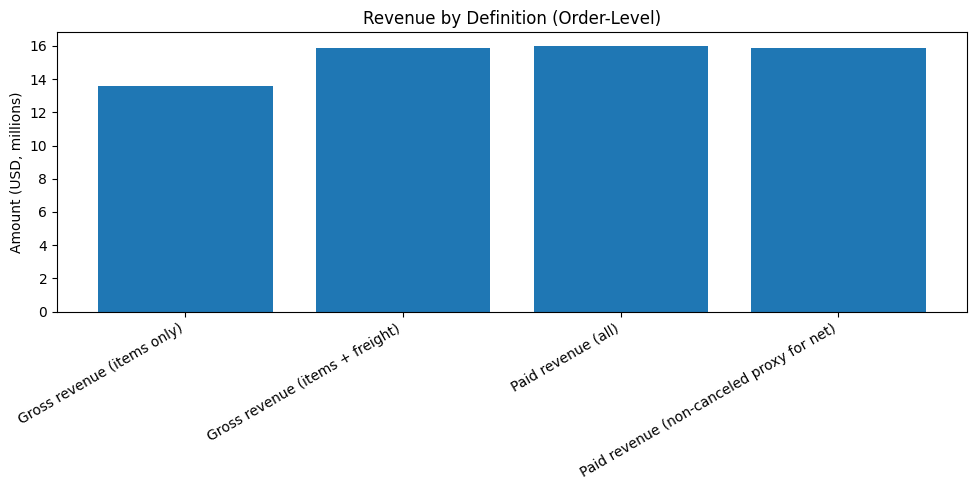

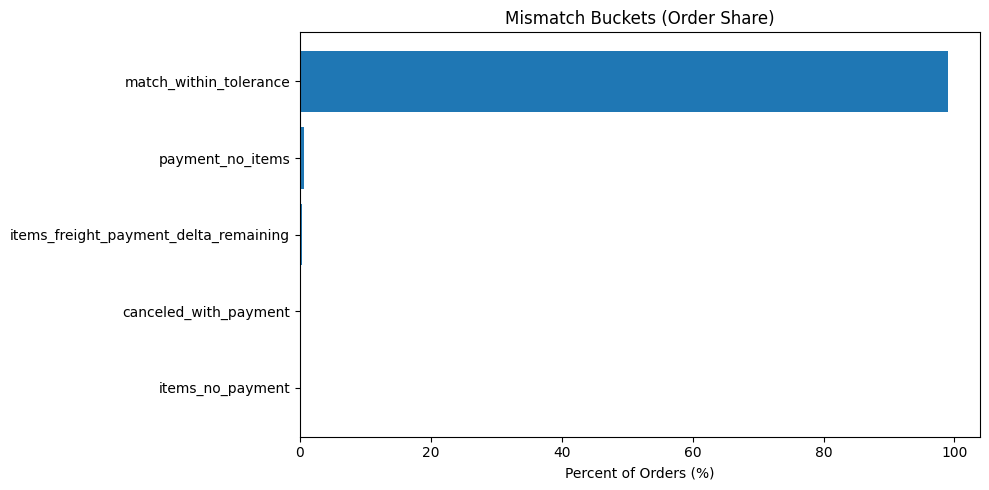

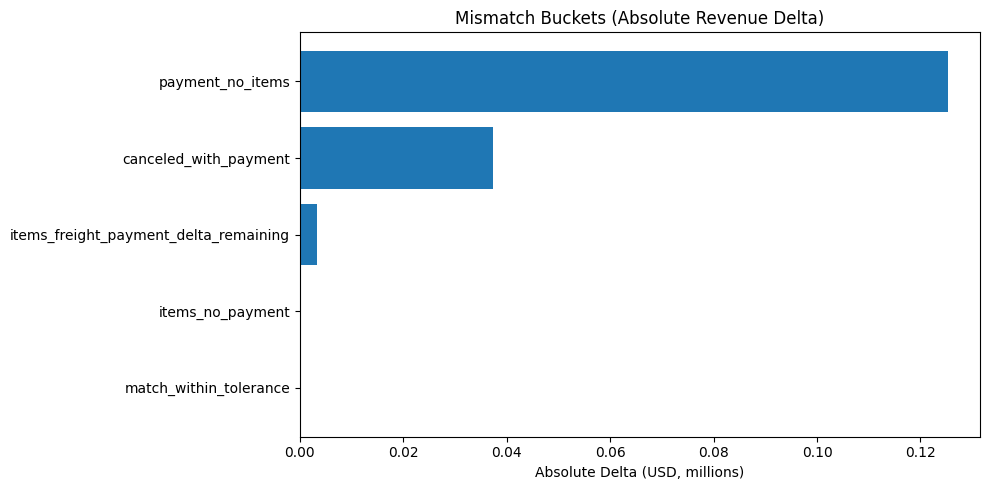

In [ ]:
# Executive Summary Visuals
import matplotlib.pyplot as plt
import pandas as pd

# 1. Revenue definition comparison
rev_plot = summary.copy()

# Ensure numeric + readable
rev_plot["amount"] = pd.to_numeric(rev_plot["amount"], errors="coerce")
rev_plot = rev_plot.dropna(subset=["amount"]).copy()
rev_plot["amount_m"] = rev_plot["amount"] / 1_000_000

plt.figure(figsize=(10, 5))
plt.bar(rev_plot["definition"], rev_plot["amount_m"])
plt.ylabel("Amount (USD, millions)")
plt.title("Revenue by Definition (Order-Level)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


# 2. Mismatch source breakdown

# bucket_summary includes: mismatch_bucket, orders, abs_delta, pct_orders

bucket_plot = bucket_summary.copy()

# Clean up
bucket_plot["pct_orders"] = pd.to_numeric(bucket_plot["pct_orders"], errors="coerce")
bucket_plot["abs_delta"] = pd.to_numeric(bucket_plot["abs_delta"], errors="coerce")

# Sort by order share
bucket_plot = bucket_plot.sort_values("pct_orders", ascending=True)

plt.figure(figsize=(10, 5))
plt.barh(bucket_plot["mismatch_bucket"], bucket_plot["pct_orders"])
plt.xlabel("Percent of Orders (%)")
plt.title("Mismatch Buckets (Order Share)")
plt.tight_layout()
plt.show()

# Show which buckets drive the $ mismatch
bucket_plot2 = bucket_summary.copy()
bucket_plot2["abs_delta"] = pd.to_numeric(bucket_plot2["abs_delta"], errors="coerce")
bucket_plot2 = bucket_plot2.sort_values("abs_delta", ascending=True)
bucket_plot2["abs_delta_m"] = bucket_plot2["abs_delta"] / 1_000_000

plt.figure(figsize=(10, 5))
plt.barh(bucket_plot2["mismatch_bucket"], bucket_plot2["abs_delta_m"])
plt.xlabel("Absolute Delta (USD, millions)")
plt.title("Mismatch Buckets (Absolute Revenue Delta)")
plt.tight_layout()
plt.show()